In [4]:
!pip install roboflow --quiet
!pip install wandb --quiet
!pip install ultralytics --quiet

In [33]:
import os
import shutil
from ultralytics import YOLO
import wandb
from google.colab import userdata
from roboflow import Roboflow
import pandas as pd

In [6]:
try:
    rf_key = userdata.get('Roboflow')
    wandb_key = userdata.get('WanDB')
except userdata.SecretNotFoundError:
    print("Error: Pastikan 'secret' Anda di Colab dinamai 'Roboflow' dan 'WanDB'")
except userdata.NotebookAccessError:
    print("Error: Pastikan Anda sudah menyalakan 'Akses notebook' (toggle biru) untuk secret Anda.")
    raise

In [7]:
wandb.login(key=wandb_key)

invalid escape sequence '\/'
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aliframadhan2410 (aliframadhan2410-institute-of-ten-nopember) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
rf = Roboflow(api_key=rf_key)

In [9]:
project = rf.workspace("computer-vision-exercise").project("panoptic-indoor-segmentation-7d7wi")

loading Roboflow workspace...
loading Roboflow project...


In [10]:
dataset = project.version(1).download("yolov8")


Extracting Dataset Version Zip to panoptic-indoor-segmentation-1 in yolov8:: 100%|██████████| 3444/3444 [00:02<00:00, 1647.45it/s]


In [11]:
DATA_YAML = os.path.join(dataset.location, "data.yaml")

In [12]:
WANDB_PROJECT_NAME = "proyek-maskrcnn-indoor"
WANDB_RUN_NAME = "yolov8s-seg-run-optimal"

try:
    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=WANDB_RUN_NAME,
        job_type="training",
        config={
            "model": "yolov8s-seg",
            "epochs": 20,
            "imgsz": 640,
            "batch": 16,
            "lr0": 0.01,
            "lrf": 0.01,
            "optimizer": "AdamW"
        }
    )
    print(f"WandB terinisialisasi: Project '{WANDB_PROJECT_NAME}', Run '{WANDB_RUN_NAME}'")
except Exception as e:
    print(f"ERROR: WandB gagal diinisialisasi. Lanjutkan tanpa WandB. Detail: {e}")
    run = None


WandB terinisialisasi: Project 'proyek-maskrcnn-indoor', Run 'yolov8s-seg-run-optimal'


In [13]:
MODEL_YOLO = "yolov8s-seg.pt"
EPOCHS = 20
BATCH = 8
IMG_SIZE = 640

model = YOLO(MODEL_YOLO)

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    val=True,
    save=True,
    exist_ok=True,
    workers=8,
)

print("\n--- 5. Pelatihan Selesai ---")
print("Metrik evaluasi akhir (Mask AP):")
print(f"mAP@.50:.95 (Mask AP): {results.box.maps[-1]}")
print(f"mAP@.50 (Mask AP): {results.box.map50}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/panoptic-indoor-segmentation-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s-seg-run-optimal, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

In [15]:
metrics = model.val()

print("\n--- Metrik Bounding Box (Deteksi Objek) ---")
print(f"Precision (Box, mAP@.50):{metrics.box.map50:.4f}")
print(f"Precision (Box, mAP@.50:.95): {metrics.box.map:.4f}")
print(f"Mean Recall (Box):{metrics.box.mr:.4f}")

print("\n--- Metrik Mask (Segmentasi Instance) ---")
print(f"Precision (Mask, mAP@.50):{metrics.seg.map50:.4f}")
print(f"Precision (Mask, mAP@.50:.95): {metrics.seg.map:.4f}")

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1997.2±773.4 MB/s, size: 60.1 KB)
val: Scanning /content/panoptic-indoor-segmentation-1/valid/labels.cache... 166 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 166/166 224.7Kit/s 0.0s
val: /content/panoptic-indoor-segmentation-1/valid/images/182169057_jpg.rf.9d57ab9ea394c54447f4fda853327b35.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.1s/it 11.8s
                   all        166       2021      0.537      0.345      0.342      0.263      0.534      0.343      0.336       0.24
              backpack          2          2          0          0     0.0598     0.0478          0          0     0.0598     0.0359
                   bed          4          6          0          0     0.0715     0.0539          0

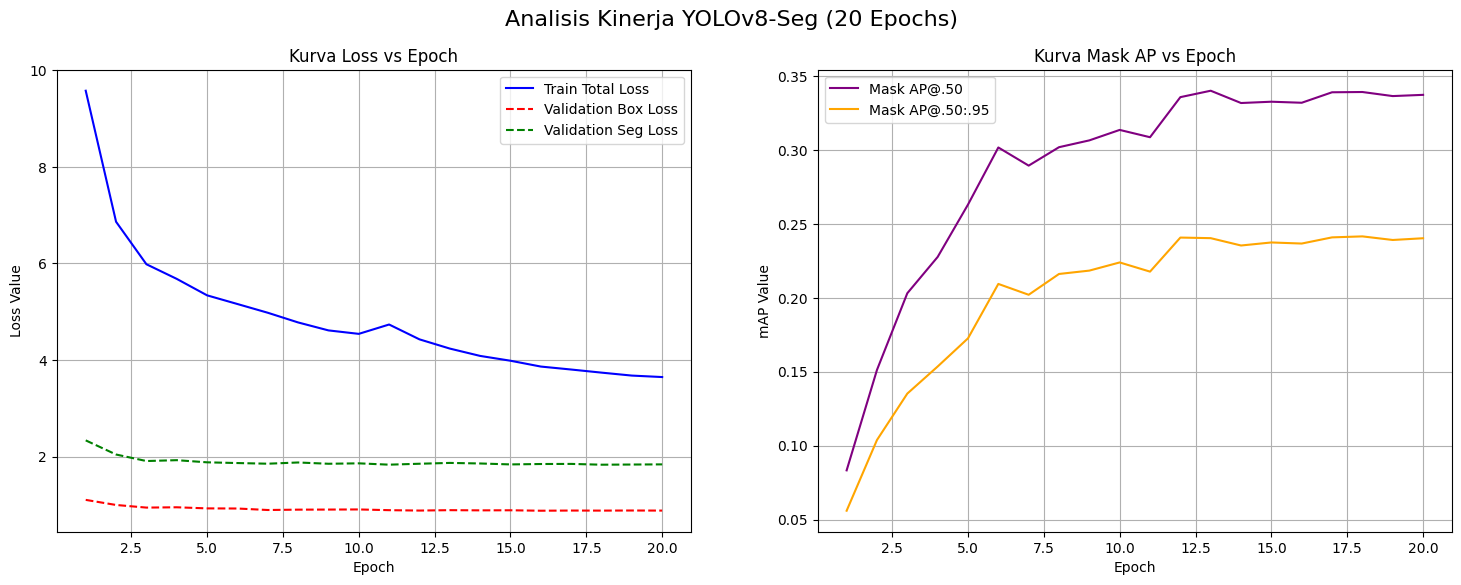

In [34]:
RESULTS_CSV_PATH = os.path.join(results.save_dir, "results.csv")

if os.path.exists(RESULTS_CSV_PATH):
    df = pd.read_csv(RESULTS_CSV_PATH)

    df.columns = df.columns.str.strip()

    df['epoch'] = df['epoch'].astype(int)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    total_train_loss = (
        df['train/box_loss'] +
        df['train/cls_loss'] +
        df['train/dfl_loss'] +
        df.get('train/seg_loss', 0)
    )

    ax[0].plot(df['epoch'], total_train_loss, label='Train Total Loss', color='blue')
    ax[0].plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss', color='red', linestyle='--')
    ax[0].plot(df['epoch'], df['val/seg_loss'], label='Validation Seg Loss', color='green', linestyle='--')
    ax[0].set_title('Kurva Loss vs Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss Value')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(df['epoch'], df['metrics/mAP50(M)'], label='Mask AP@.50', color='purple')
    ax[1].plot(df['epoch'], df['metrics/mAP50-95(M)'], label='Mask AP@.50:.95', color='orange')
    ax[1].set_title('Kurva Mask AP vs Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('mAP Value')
    ax[1].legend()
    ax[1].grid(True)

    plt.suptitle('Analisis Kinerja YOLOv8-Seg (20 Epochs)', fontsize=16)
    plt.show()

else:
    print(f"❌ File metrik CSV tidak ditemukan di: {RESULTS_CSV_PATH}")

In [30]:
import glob
import random
import matplotlib.pyplot as plt

test_dir = os.path.join(dataset.location, "test", "images")
image_files = glob.glob(os.path.join(test_dir, "*.jpg")) + glob.glob(os.path.join(test_dir, "*.png"))


image 1/1 /content/panoptic-indoor-segmentation-1/test/images/330_jpg.rf.2a3d97b32cfaaff7ff39b7c5080d05ca.jpg: 640x640 3 persons, 1 wall-other-merged, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s-seg-local-predict

image 1/1 /content/panoptic-indoor-segmentation-1/test/images/151_jpg.rf.77658dbd1c36a1b7af6f9ff851158d5f.jpg: 640x640 3 beds, 1 ceiling-merged, 1 floor-other-merged, 1 floor-wood, 4 pillows, 2 table-mergeds, 2 wall-other-mergeds, 21.1ms
Speed: 2.9ms preprocess, 21.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/predict/yolov8s-seg-local-predict

image 1/1 /content/panoptic-indoor-segmentation-1/test/images/045_jpg.rf.317a799268d30acddd6d87ec6ab12986.jpg: 640x640 2 beds, 1 blanket, 1 chair, 1 door-stuff, 1 floor-other-merged, 2 floor-woods, 4 pillows, 1 potted plant, 2 table-mergeds, 2 wall-other-mergeds, 1 window-othe

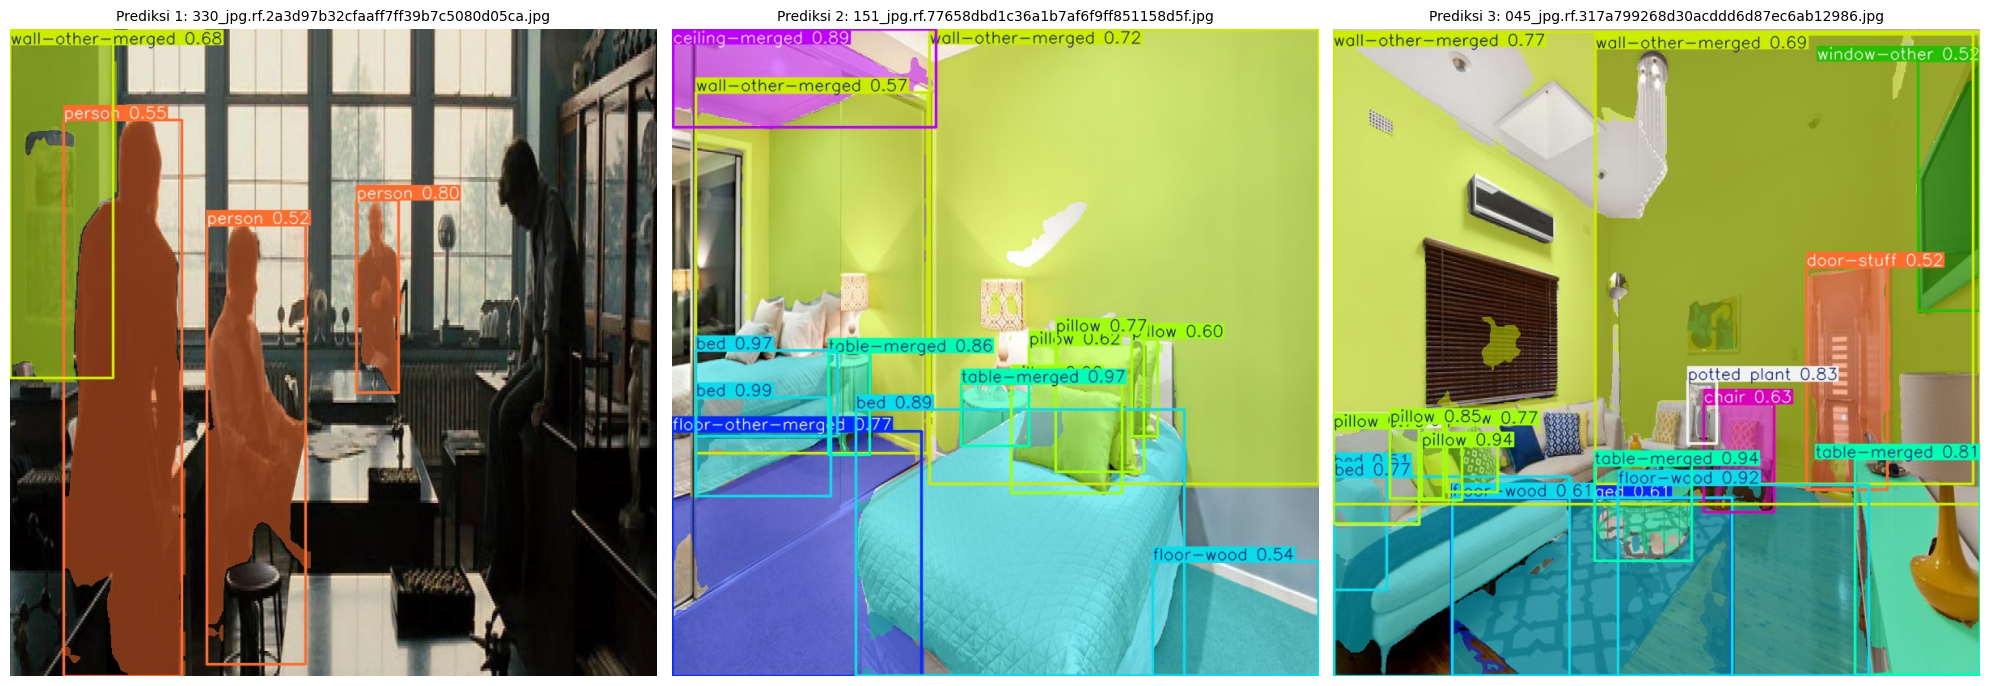

In [29]:
if len(image_files) < 3:
    print(f"Hanya ditemukan {len(image_files)} gambar test. Tidak cukup untuk 3 gambar random.")
else:
    random_images = random.sample(image_files, 3)

    WEIGHTS_PATH = os.path.join(results.save_dir, "weights", "best.pt")
    trained_model = YOLO(WEIGHTS_PATH)

    PREDICT_DIR_NAME = "yolov8s-seg-local-predict"
    PREDICT_PROJECT_DIR = "runs/predict"

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    for i, img_path in enumerate(random_images):
        predict_results = trained_model.predict(
            source=img_path,
            conf=0.50,
            save=True,
            project=PREDICT_PROJECT_DIR,
            name=PREDICT_DIR_NAME,
            exist_ok=True,
            show_labels=True,
            show_boxes=True
        )

        predict_dir = os.path.join(PREDICT_PROJECT_DIR, PREDICT_DIR_NAME)
        visualized_path = os.path.join(predict_dir, os.path.basename(img_path))

        if os.path.exists(visualized_path):
            img = plt.imread(visualized_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Prediksi {i+1}: {os.path.basename(img_path)}", fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "Gambar Tidak Ditemukan", ha='center', va='center')
            axes[i].axis('off')
            print(f"Gagal menemukan visualisasi di {visualized_path}")

    plt.tight_layout()
    plt.show()